In [1]:
import math
import numpy as np
import re
import string
import os
import cv2 as cv
from google.colab.patches import cv2_imshow

from collections import Counter
from matplotlib import pyplot as plt

import random
from random import randint
from PIL import Image, ImageFont, ImageDraw, ImageOps

from os import pathconf

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
  

Mounted at /content/drive


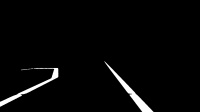

(112, 200)


In [5]:
path = "/content/drive/MyDrive/im_learn_img/"
path_fwd= path + 'forward/'
fwd_imgs = os.listdir(path_fwd)

path_left = path + 'left/'
left_imgs = os.listdir(path_left)

path_right= path + 'right/'
right_imgs = os.listdir(path_right)

path_stationary = path + 'stationary/'
stationary_imgs = os.listdir(path_stationary)

path_left_fwd = path + 'left_forward/'
left_fwd_imgs = os.listdir(path_left_fwd)

path_right_fwd = path + 'right_forward/'
right_fwd_imgs = os.listdir(path_right_fwd)

img = cv.imread(path_left_fwd+ left_fwd_imgs[0],0)
cv2_imshow(img)
print(img.shape)

#plates.remove(".ipynb_checkpoints")
#print(path_fwd[5])

# could maybe reduce size on my images

In [6]:
from posix import NGROUPS_MAX
# associated labels for each folder
#['0.0', '0.0', '0.0', '0.0', '0.0', '0.0'] stationary -> [1,0,0,0,0,0]
#['0.295245', '0.0', '0.0', '0.0', '0.0', '0.0'] forward ->[0,1,0,0,0,0]
#['0.0', '0.0', '0.0', '0.0', '0.0', '1.5944049'] left -> [0,0,1,0,0,0]
#['0.0', '0.0', '0.0', '0.0', '0.0', '-1.5944049'] right-> [0,0,0,1,0,0]
# ['0.295245', '0.0', '0.0', '0.0', '0.0', '1.5944049'] forward left ->[0,0,0,0,1,0]
#['0.295245', '0.0', '0.0', '0.0', '0.0', '-1.5944049'] forward right-> [0,0,0,0,0,1]

# note labels should be[1,0,0,0,0] representing one of these states
def arrays_for_nn():
  photoArray = []
  vel_cmd_Array = []

  num = len(stationary_imgs)
  print("Stationary: " + str(num))
  for stationary in range(num):
    photoArray.append(cv.imread(path_stationary+stationary_imgs[stationary],0))
    vel_cmd_Array.append([1,0,0,0,0,0])
    print("stationary")

  num = len(fwd_imgs)
  print("Fwd: " + str(num))
  for fwd in range(num):
    photoArray.append(cv.imread(path_fwd+fwd_imgs[fwd],0))
    vel_cmd_Array.append([0,1,0,0,0,0])
    print("fwd")

  num = len(left_imgs)
  print("Left: " + str(num))
  for left in range(num):
    photoArray.append(cv.imread(path_left+left_imgs[left],0))
    vel_cmd_Array.append([0,0,1,0,0,0])
    print("left")

  num = len(right_imgs)
  print("Right: " + str(num))
  for right in range(num):
    photoArray.append(cv.imread(path_right+right_imgs[right],0))
    vel_cmd_Array.append([0,0,0,1,0,0])
    print("right")

  num = len(left_fwd_imgs)
  print("Left Fwd: " + str(num))
  for left in range(num):
    photoArray.append(cv.imread(path_left_fwd+left_fwd_imgs[left],0))
    vel_cmd_Array.append([0,0,0,0,1,0])
    print("fwd left")

  num = len(right_fwd_imgs)
  print("Right Fwd: " + str(num))
  for right in range(num):
    photoArray.append(cv.imread(path_right_fwd+right_fwd_imgs[right],0))
    vel_cmd_Array.append([0,0,0,0,0,1])
    print("fwd right")

  return photoArray, vel_cmd_Array

# need to convert this into same format as other np.ndarray
# convert label into np array as well
# could graph length of each set of images on a graph,
# plt.bar(countTrainingSet.keys(), countTrainingSet.values(), 5)

In [ ]:
#photoArray, vel_cmd_Array = arrays_for_nn()

In [7]:
# neural net validation split 0.2
VALIDATION_SPLIT = 0.2
%tensorflow_version 1.14.0

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [8]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [9]:
vel_cmd_model = models.Sequential()
# should try to match this to what is given in the document
# input shape of my image
# need more convolutions I think
# vel_cmd_model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                              input_shape=(200,112,1)))
# vel_cmd_model.add(layers.MaxPooling2D((2, 2)))
# vel_cmd_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# vel_cmd_model.add(layers.MaxPooling2D((2, 2)))
# vel_cmd_model.add(layers.Flatten())
# vel_cmd_model.add(layers.Dropout(0.5))
# vel_cmd_model.add(layers.Dense(512, activation='relu'))
# vel_cmd_model.add(layers.Dense(6, activation='softmax'))
# vel_cmd_model.summary()

# suggested model from https://arxiv.org/pdf/1604.07316.pdf
vel_cmd_model.add(layers.Conv2D(32, (5, 5), activation='relu',
                             input_shape=(200,112,1)))
vel_cmd_model.add(layers.MaxPooling2D((2, 2)))
vel_cmd_model.add(layers.Conv2D(32, (5, 5), activation='relu'))
vel_cmd_model.add(layers.MaxPooling2D((2, 2)))
vel_cmd_model.add(layers.Conv2D(32, (5, 5), activation='relu'))
vel_cmd_model.add(layers.MaxPooling2D((2, 2)))
vel_cmd_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
vel_cmd_model.add(layers.MaxPooling2D((2, 2)))
vel_cmd_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
vel_cmd_model.add(layers.MaxPooling2D((2, 2)))
vel_cmd_model.add(layers.Flatten())
vel_cmd_model.add(layers.Dropout(0.5))
vel_cmd_model.add(layers.Dense(1164, activation='relu'))
vel_cmd_model.add(layers.Dense(100, activation='relu'))
vel_cmd_model.add(layers.Dense(50, activation='relu'))
vel_cmd_model.add(layers.Dense(10, activation='relu'))
vel_cmd_model.add(layers.Dense(6, activation='softmax'))
vel_cmd_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 108, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 54, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 50, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 21, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 10, 32)        0         
_________________________________________

In [10]:
LEARNING_RATE = 1e-4
# could change learning rate to fluctuate less
vel_cmd_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [11]:
imgArray, imgEncodeArray = arrays_for_nn()

Stationary: 207
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stationary
stati

In [12]:
reset_weights(vel_cmd_model)
imgArray = np.asarray(imgArray)
imgEncodeArray = np.asarray(imgEncodeArray)
# TODO ned to reshape this to correct thign
imgArray = imgArray.reshape((-1, 200, 112, 1))

# need to decrease batch size and size of images
# should change batch size to what it was
history_conv_vel = vel_cmd_model.fit(imgArray, imgEncodeArray, 
                              validation_split=VALIDATION_SPLIT,
                              epochs=50, 
                              batch_size=10)

Train on 910 samples, validate on 228 samples
Epoch 1/50
910/910 [==============================] - 6s 6ms/sample - loss: 1.0446 - acc: 0.6527 - val_loss: 3.5076 - val_acc: 0.0000e+00
Epoch 2/50
910/910 [==============================] - 2s 2ms/sample - loss: 0.9159 - acc: 0.6835 - val_loss: 3.4464 - val_acc: 0.0000e+00
Epoch 3/50
910/910 [==============================] - 2s 2ms/sample - loss: 0.8138 - acc: 0.6879 - val_loss: 2.5919 - val_acc: 0.0000e+00
Epoch 4/50
910/910 [==============================] - 2s 2ms/sample - loss: 0.7248 - acc: 0.7286 - val_loss: 3.0311 - val_acc: 0.0000e+00
Epoch 5/50
910/910 [==============================] - 2s 2ms/sample - loss: 0.6403 - acc: 0.7615 - val_loss: 3.0418 - val_acc: 0.0000e+00
Epoch 6/50
910/910 [==============================] - 2s 2ms/sample - loss: 0.5866 - acc: 0.7879 - val_loss: 2.5752 - val_acc: 0.0395
Epoch 7/50
910/910 [==============================] - 2s 2ms/sample - loss: 0.5448 - acc: 0.7923 - val_loss: 2.1782 - val_acc: 0.0

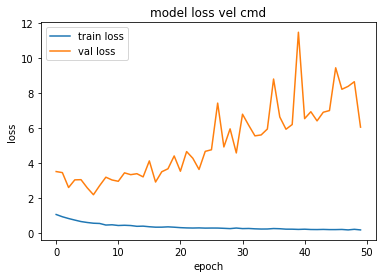

In [13]:
plt.plot(history_conv_vel.history['loss'])
plt.plot(history_conv_vel.history['val_loss'])
plt.title('model loss vel cmd')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

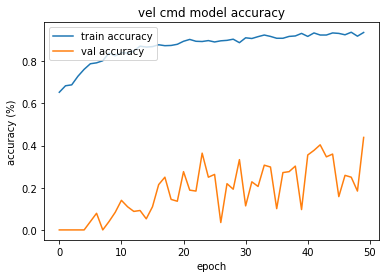

In [14]:
plt.plot(history_conv_vel.history['acc'])
plt.plot(history_conv_vel.history['val_acc'])
plt.title('vel cmd model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# #characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
# characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# #TODO how to change characters so it prints out the maximum val in vel cmds
# true = imgEncodeArray
# true_char = [characters[np.argmax(i)] for i in true]

# predicted = char_model.predict(charArray)
# predicted_char = [characters[np.argmax(i)] for i in predicted]

# cm = confusion_matrix(true_char, predicted_char, labels=list(characters))
# cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(characters))

# fig, ax = plt.subplots(figsize=(10,10))
# cm_display.plot(ax=ax)
# plt.show()

In [15]:
vel_cmd_model.save('vel_nn_4')